# BRACE
A notebook tutorial of BRACE. MRSAA-c extended model implementation in landlab.

**Made by Sergio Villamarin**

### Setup

Our MRSAA-c implementation is done on Landlab's Network Model Grid (NMG), you can think of it as a graph. So let's see a quick example of this

<Axes: xlabel='x', ylabel='y'>

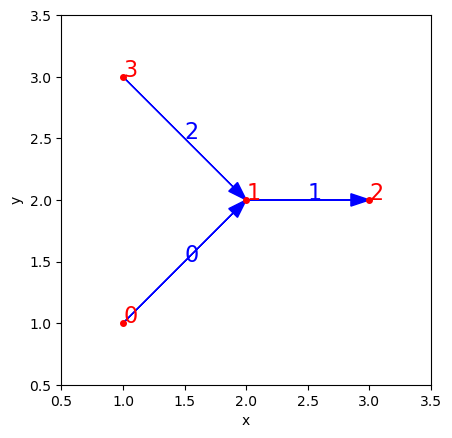

In [94]:
from landlab import NetworkModelGrid
import landlab.plot.graph as graph

x_of_nodes = [1, 1, 2, 3]
y_of_nodes = [3, 1, 2, 2]
links = [(0,2) ,(1,2), (2,3)]

ngrid = NetworkModelGrid((y_of_nodes, x_of_nodes), links)
graph.plot_graph(ngrid, at="node,link", with_id=True)


This allows us to represent river networks and run processes exclusive to them on this grid. In practice we use topographic data which is usually read as a Raster file (equally spaced 2D grid of topographic elevation). For now we will use the following single channel generated raster

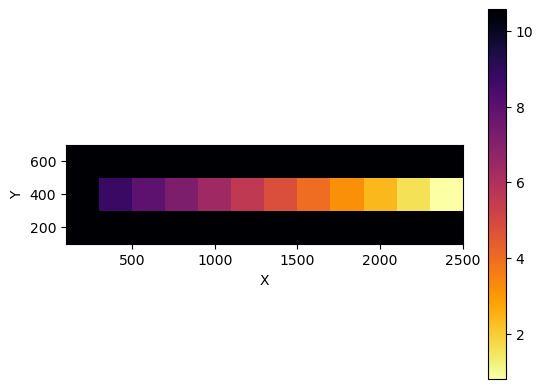

In [95]:
from landlab import imshow_grid
from landlab.io import read_esri_ascii
# store it as a raster object
rastergrid, topography = read_esri_ascii("short_reach.asc")
rastergrid.add_field("topographic__elevation", topography)
# plot spatially the topography
imshow_grid(rastergrid, rastergrid.at_node["topographic__elevation"], cmap='inferno_r')

we can then use landlab's function ```network_grid_from_raster``` to create a NMG (hard to see well but you can see the nodes and the arrows indices on it)

<Axes: xlabel='x', ylabel='y'>

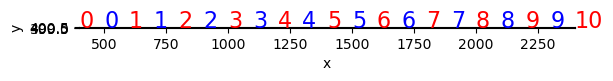

In [96]:
from landlab.grid.create_network import network_grid_from_raster

ngrid = network_grid_from_raster(rastergrid)
graph.plot_graph(ngrid, at="node,link", with_id=True)

We should set up the parameters of the network or sediment but for now we will use default values. Additionally we need the direction of the flow as a ```FlowDirector``` object

In [97]:
from landlab.components import BedRockAbrasionCoverEroder as BRACE
from landlab.components import FlowDirectorSteepest

flow_director = FlowDirectorSteepest(ngrid)
flow_director.run_one_step()

And finally create an instance of our component

In [98]:
nety = BRACE(ngrid, flow_director)

adding discharge
adding flood_intermittency
adding channel_width
adding sediment_grain_size
adding sed_capacity
adding macroroughness
adding mean_alluvium_thickness


Note that some necesary parameters are automatically added with default values if the user doesn't provide them as parameters or field values of `ngrid`

### Basic model run

The shape of this network is a line so we can plot its field values in a fairly simple way using $x$ as the downstream distance and $y$ as a landlab field. Let's start by plotting the bedrock topography

Text(0.5, 1.0, 'Bedrock')

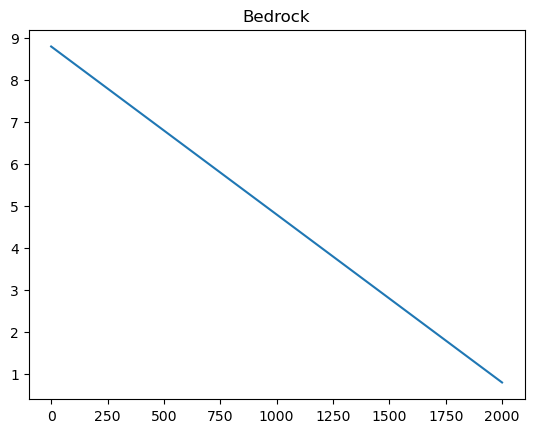

In [99]:
import matplotlib.pyplot as plt
import numpy as np
YEAR = 365.25 * 24 * 60 * 60

# x values are distance downstream (going from left to right)
xs = np.zeros_like(nety.downstream_distance)
xs[1:] = np.cumsum(nety.downstream_distance[:-1])
# y can be any grid landlab fields
ys = ngrid.at_node["bedrock"]
plt.plot(xs, ys)
plt.title("Bedrock")

Now let's see how the alluvium changes as we let the model run for half a year with a constant sediment flux `q_in` at the upstream end

In [100]:
# times of the run
dt = YEAR / 1000
one_year = round(1 * YEAR / dt)
total_time = round(0.5 * one_year)
record_time = round(0.1 * one_year)

0.0
0.1
0.2
0.3
0.4
0.5


Text(0.5, 1.0, 'mean alluvium cover')

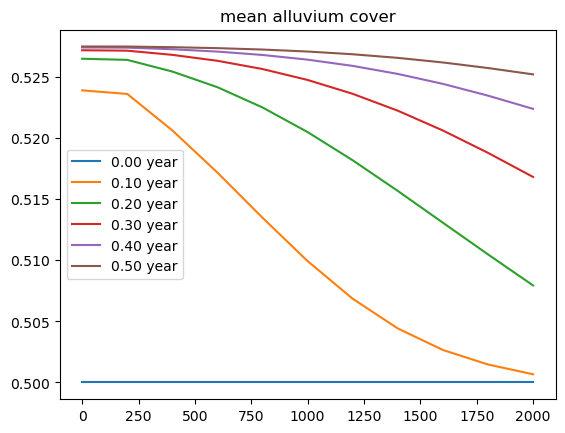

In [101]:
# plot every record time
for t in range(total_time + 1):
    if t % record_time == 0:
        # plot the new alluvium
        print(t / one_year)
        ys = ngrid.at_node["mean_alluvium_thickness"]
        plt.plot(xs, ys, label=f"{t / one_year :.2f} year")
    nety.run_one_step(dt=dt, q_in=0.000834)
plt.legend()
plt.title("mean alluvium cover")

The slope and discharge we pick accumulates the sediment transported at the downstream end. The outlet default is limited to 1 macroroughness unit (1 m in this case) so any excess sediment after that is pushed out of the network.

## Setting up parameters

We are now ready to see what kind of parameters we can change for a model run. Let's see the help of a `BedRockAbrassionCoverEroder` object

In [102]:
nety?

Type:           BedRockAbrasionCoverEroder
String form:    <landlab.components.Sergio.bedrock_abrassion_cover_eroder.BedRockAbrasionCoverEroder object at 0x000002087921D210>
File:           c:\users\sergio\documents\github\landlab\landlab\components\sergio\bedrock_abrassion_cover_eroder.py
Docstring:     
BedRockAbrasionCoverEroder or BRACE is a landlab implementation of the
MRSAA-c mode from Zhang's 2017 paper. BRACE models Saltation, Abrassion,
and Alluvium cover on a river reach. It uses the scale of the macroroughness
and sediment properties to model the change in the alluvium and erosion
of the bed.

Created by Sergio Villamarin
Init docstring:
Creates a BedRockAbrasionCoverEroder object. If field values
are provided as parameters in this function with the documented
field name, they will be created if the did not exist before.
It won't replace preset values in landlab fields.

If needed values are not provided or preset then they will be
created using values from main ref paper.


As you can see, we can provide multiple hydraulic parameters, some of these are:
- `float` so a single value is used along the whole network and some are 
- `grid` which means the values at each node of the grid should be provided (e.g. same shape as `ngrid.at_node["bedrock"]`)

Let's use the same network again and set the initial alluvium cover and discharge

In [103]:
#------ Setup again
# read the raster again
rastergrid, topography = read_esri_ascii("short_reach.asc")
rastergrid.add_field("topographic__elevation", topography)
# make it a network
ngrid = network_grid_from_raster(rastergrid)
# direction of the flow
flow_director = FlowDirectorSteepest(ngrid)
flow_director.run_one_step()


#------ Initialize the component with new parameters
nety = BRACE(ngrid, flow_director,
             discharge = 150,
             mean_alluvium_thickness = 1)

adding flood_intermittency
adding channel_width
adding sediment_grain_size
adding sed_capacity
adding macroroughness


And now let's run it for half a year again and see how the alluvium layer changes

In [104]:
# times of the run
dt = YEAR / 1000
one_year = round(1 * YEAR / dt)
total_time = round(0.5 * one_year)
record_time = round(0.1 * one_year)

0.0
0.1
0.2
0.3
0.4
0.5


Text(0.5, 1.0, 'mean alluvium cover')

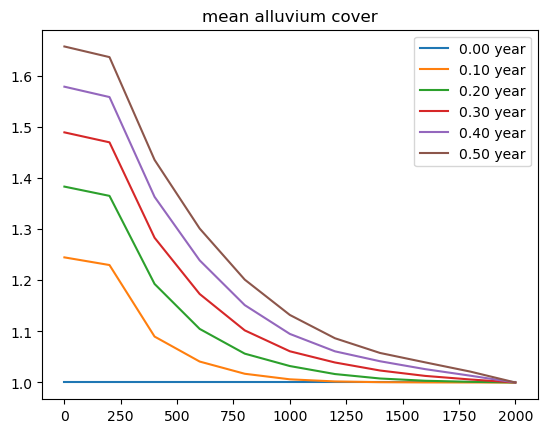

In [105]:
# plot every record time
for t in range(total_time + 1):
    if t % record_time == 0:
        # plot the new alluvium
        print(t / one_year)
        ys = ngrid.at_node["mean_alluvium_thickness"]
        plt.plot(xs, ys, label=f"{t / one_year :.2f} year")
    nety.run_one_step(dt=dt, q_in=0.000834)
plt.legend()
plt.title("mean alluvium cover")

The default water discharge value is $300 m^3/s$. Since we halved discharge to $150 m^3/s$ we are not able to transport the sediment being feed at the upstream end which starts accumulating upstream. 

### Changing boundary conditions

Boundary conditions are provided in the form of sediment feed upstream and sediment flux out downstream. The previous examples illustrate the default behavior at the downstream end (outlet) where the sediment is only "flush out" after it acumulates up to full cover.

Let's see how the alluvium changes over a smaller time scale with the original discharge but changing the downstream boundary condition to a fixed high flux out

In [110]:
#------ Setup again
# read the raster again
rastergrid, topography = read_esri_ascii("short_reach.asc")
rastergrid.add_field("topographic__elevation", topography)
# make it a network
ngrid = network_grid_from_raster(rastergrid)
# direction of the flow
flow_director = FlowDirectorSteepest(ngrid)
flow_director.run_one_step()


#------ Initialize the component with new parameters
nety = BRACE(ngrid, flow_director)

adding discharge
adding flood_intermittency
adding channel_width
adding sediment_grain_size
adding sed_capacity
adding macroroughness
adding mean_alluvium_thickness


In [111]:
# times of the run
DAY = 24*60*60
dt = DAY / 10
one_day = round(DAY / dt)
total_time = round(50 * one_day)
record_time = round(5 * one_day)

0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0


Text(0.5, 1.0, 'mean alluvium cover')

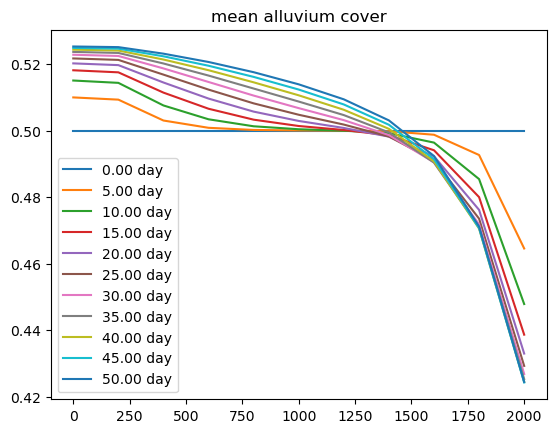

In [112]:
# plot every record time
for t in range(total_time + 1):
    if t % record_time == 0:
        # plot the new alluvium
        print(t / one_day)
        ys = ngrid.at_node["mean_alluvium_thickness"]
        plt.plot(xs, ys, label=f"{t / one_day :.2f} day")
    nety.run_one_step(dt=dt, q_in=0.000834, outlet="set_value", q_out=0.002)
plt.legend()
plt.title("mean alluvium cover")

We can see directly the sediment capacity

['short_flat_reach.asc']

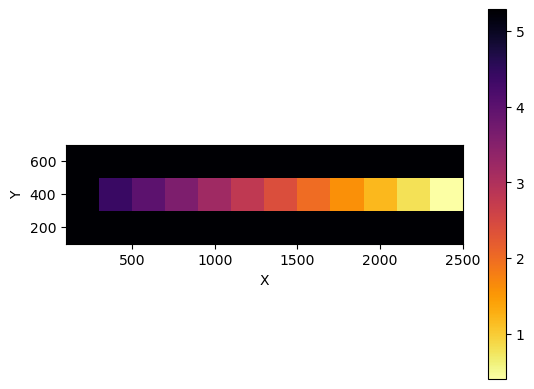

In [109]:
# if I want to generate a longer reach, can be ignored otherwise
# grid parameters
from landlab.io.esri_ascii import write_esri_ascii
from landlab.grid import RasterModelGrid
from landlab import imshow_grid

reach_lenght = 200
total_length = 2000 + reach_lenght
slope = 0.002
steepness = slope * reach_lenght
# grid geometry creation
n = round(total_length / reach_lenght)
shape = (3, n + 1)
cliff_height = steepness * n * 1.2 + 0.01
topography = [cliff_height] * (3 * (n+1))
# create the grid
for i in range(n):
    topography[n + i + 2] = steepness * (n - i)

raster2save = RasterModelGrid(shape, reach_lenght, (200, 200))
raster2save.add_field("topographic__elevation", topography)
imshow_grid(raster2save, raster2save.at_node["topographic__elevation"], cmap='inferno_r')
write_esri_ascii("short_flat_reach.asc", raster2save, clobber=True)